## Win/Loss Rating Model Prediction

Load the model and make predictions

In [125]:
import requests
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('fivethirtyeight')
%matplotlib inline

### Get a list of all CS Games

In [195]:
r = requests.get('https://thunderpick.com/api/matches')
games = pd.DataFrame(r.json()['data'])
games = games[games.gameId == 6].sort_values('championship')

bet_games = []
for i,v in games.iterrows():
    if((v['isTournament'] == False )& (v['canWager'] == True)):
        ratio = v['matchBet']['buckets'][0]['amount']/v['matchBet']['buckets'][1]['amount']
        odds = (ratio**-1+1, ratio+1)
        wr = (odds[1]/np.sum(odds)*100., odds[0]/np.sum(odds)*100.)
        det = requests.get('https://thunderpick.com/api/matches/'+str(v['id'])).json()['data']
        print('Date: %s  |  Event: %s  | (BO%s) %s vs. %s  |  (%.1f:%.1f) | Total Coins: %i' % 
              (v['startTime'][:10], v['championship'], det['bestOfMaps'], v['matchBet']['buckets'][0]['label'], 
               v['matchBet']['buckets'][1]['label'], wr[0], wr[1], v['matchBet']['amount']))
        bet_games.append({'1': v['matchBet']['buckets'][0]['label'], '2': v['matchBet']['buckets'][1]['label'], 'bo': det['bestOfMaps'], 'o1': odds[0], 'o2': odds[1], 'wr': wr[0]})
bet_games = pd.DataFrame(bet_games)

Date: 2017-10-23  |  Event: DaddySkins Cup  | (BO3) Ex-Outlaws vs. Nexus  |  (60.3:39.7) | Total Coins: 3541
Date: 2017-10-23  |  Event: Douyu CS:GO  | (BO1) Eclipse.ZB vs. LGD  |  (30.9:69.1) | Total Coins: 4275
Date: 2017-10-25  |  Event: ECS Season 4 Development League  | (BO1) fnatic vs. EnVyUs  |  (45.0:55.0) | Total Coins: 2000
Date: 2017-10-24  |  Event: ECS Season 4 Development League  | (BO1) G2 vs. Heroic  |  (60.0:40.0) | Total Coins: 2000
Date: 2017-10-25  |  Event: ECS Season 4 Development League  | (BO1) FaZe vs. mousesports  |  (62.3:37.7) | Total Coins: 10091
Date: 2017-10-25  |  Event: ECS Season 4 Development League  | (BO1) mousesports vs. FaZe  |  (37.0:63.0) | Total Coins: 2000
Date: 2017-10-26  |  Event: ECS Season 4 Development League  | (BO1) Liquid vs. SK  |  (40.0:60.0) | Total Coins: 10000
Date: 2017-10-26  |  Event: ECS Season 4 Development League  | (BO1) SK vs. Liquid  |  (61.0:39.0) | Total Coins: 2050
Date: 2017-10-26  |  Event: ECS Season 4 Development 

## Load Ratings Model

In [220]:
TEAM_SET = 'mdlna'

teams = np.load('saved_model/'+TEAM_SET+'/teams.npy')
maps = np.load('saved_model/'+TEAM_SET+'/maps.npy')
filt = np.load('saved_model/'+TEAM_SET+'/filter_teams.npy')
h_teams = pd.read_csv('hltv_csv/teams.csv')
h_teams = h_teams.set_index('ID').loc[teams]
h_teams.loc[7723, 'Name'] = 'Morior Invictus'
h_teams.loc[8241, 'Name'] = 'ex-Nitrious'
h_teams_filt = h_teams[h_teams.Name.isin(filt)]

def prep_pymc_model(n_teams, n_maps):
    with pm.Model() as rating_model:
        omega = pm.HalfCauchy('omega', 0.5)
        tau = pm.HalfCauchy('tau', 0.5)
        rating = pm.Normal('rating', 0, omega, shape=n_teams)
        theta_tilde = pm.Normal('rate_t', mu=0, sd=1, shape=(n_maps, n_teams))
        rating_map = pm.Deterministic('rating | map', rating + tau * theta_tilde)
        alpha = pm.Gamma('alpha', 10, 5)
        sigma = pm.HalfCauchy('sigma', 0.5, shape=n_maps)
    return rating_model

rating_model = prep_pymc_model(len(teams), len(maps))
trace = pm.backends.text.load('saved_model/'+TEAM_SET+'/trace', model=rating_model)

## Ban/Pick Predictions

In [221]:
h_bp = pd.read_csv('hltv_csv/picksAndBans.csv').set_index('Match ID')
h_matches = pd.read_csv('hltv_csv/matchResults.csv').set_index('Match ID')[['Date']]
h_bp = h_bp.join(h_matches, how='left')
h_bp['Date'] = pd.to_datetime(h_bp['Date'])
h_bp = h_bp[h_bp['Date'] >= dt.datetime(2017,1,1)]

In [222]:
def model_mp(train, t1, t2):
    tab = train[train['Team'].isin([t1, t2])].groupby(['Team', ' Pick Type', 'Map'])['Date'].count().unstack([' Pick Type', 'Team']).fillna(0)
    return (tab/tab.sum(axis=0)).mean(level=0,axis=1)# get average

def predict_map(func, data, t1, t2):
    res = func(data, t1, t2)
    return res.sort_values('picked', ascending=False)

# Bet Predictions

In [235]:
money = 4500.
matches = bet_games[bet_games['1'].isin(filt) & bet_games['2'].isin(filt)].drop_duplicates()
def sig(x):
    return 1 / (1 + np.exp(-x))
def abs_norm_interval(start,end,loc,scale):
    return (norm.cdf(end,loc,scale) - norm.cdf(start,loc,scale)) + (norm.cdf(-1*start,loc,scale) - norm.cdf(-1*end,loc,scale))

for i,v in matches.iterrows():
    t1_id = h_teams_filt[h_teams_filt.Name == v['1']].index[0]; t1_ind = np.where(teams == t1_id)[0][0];
    t2_id = h_teams_filt[h_teams_filt.Name == v['2']].index[0]; t2_ind = np.where(teams == t2_id)[0][0];
    trace_1 = trace['rating'][:,t1_ind]; trace_2 = trace['rating'][:,t2_ind]
    mr_1 = trace_1.mean(); mr_2 = trace_2.mean();
    diff = trace_1-trace_2
    p_wl = sig(diff)
    wr_25 = np.percentile(p_wl, 25); wr_75 = np.percentile(p_wl, 75)
    kelly_pct = ((v['o1']*p_wl.mean()-(1.-p_wl.mean()))/v['o1'])*0.5
    print('%s (%.3f) vs %s (%.3f) - I:%.2f%% | P:%.2f%% - %.2f%%  -  K: %.1f%% (%i)' % 
          (v['1'], mr_1, v['2'], mr_2, v['wr'], wr_25*100, wr_75*100, kelly_pct*100., kelly_pct*money))

Mythic (0.769) vs Torqued (1.217) - I:40.00% | P:18.48% - 64.15%  -  K: 9.6% (431)
FRENCH CANADIANS (1.453) vs Gale Force (1.624) - I:60.00% | P:24.67% - 68.61%  -  K: 7.5% (338)
GX (2.712) vs SoaR (1.253) - I:60.00% | P:55.13% - 93.67%  -  K: 27.5% (1237)
Gale Force (1.624) vs Beacon (0.015) - I:55.00% | P:64.27% - 93.09%  -  K: 31.3% (1408)
LFAO (0.076) vs ANTI ECO (-1.205) - I:57.00% | P:51.83% - 92.40%  -  K: 26.2% (1180)
Iceberg (-0.223) vs ANTI ECO (-1.205) - I:60.00% | P:44.68% - 89.59%  -  K: 22.3% (1001)
GX (2.712) vs Mythic (0.769) - I:57.00% | P:68.16% - 95.81%  -  K: 32.8% (1477)
Naventic (0.760) vs Muffin Lightning (0.875) - I:45.00% | P:24.53% - 70.98%  -  K: 12.3% (551)
Adaptation (-0.759) vs Rise Nation (2.394) - I:40.00% | P:1.54% - 10.70%  -  K: -14.0% (-629)
ex-Nitrious (-0.318) vs Rise Nation (2.394) - I:26.00% | P:2.21% - 16.41%  -  K: -5.1% (-229)
Mostly Harmless (-0.876) vs Iceberg (-0.223) - I:40.00% | P:13.68% - 63.32%  -  K: 7.7% (348)
Ambition (-0.848) vs Nav

In [ ]:
 pred_maps = predict_map(model_mp, h_bp, v['1'], v['2'])
    pred_maps = pred_maps/pred_maps.sum()
    for m,s in pred_maps.iterrows():
        m_ind = np.where(maps == m)[0][0]
        trace_1 = trace['rating | map'][:,m_ind,t1_ind]; trace_2 = trace['rating | map'][:,m_ind,t2_ind]
        mr_1 = trace_1.mean(); mr_2 = trace_2.mean();
        diff = trace_1-trace_2
        p_wl = sig(diff)
        kappa = 32*sig(trace['alpha']*diff)-16.
        wr_25 = np.percentile(p_wl, 25); wr_75 = np.percentile(p_wl, 75)
        kelly_pct = ((v['o1']*p_wl.mean()-(1.-p_wl.mean()))/v['o1'])*0.25
        print('    Map: %s (%.2f)  -  %s (%.3f) vs %s (%.3f) - I:%.2f%% | P:%.2f%% - %.2f%%  -  K: %.1f%% (%i)' % 
             (m, s['picked']*100., v['1'], mr_1, v['2'], mr_2, v['wr'], wr_25*100, wr_75*100, kelly_pct*100., kelly_pct*money))
        
        p_sc = [abs_norm_interval(x[0],x[1],kappa,trace['sigma'][:,m_ind]) for x in [[1.5,3.5],[3.5,5.5],[5.5,7.5],[7.5,9.5],[9.5,16]]]
        for i,sd in enumerate(['2 - 3 Rounds', '4 - 5 rounds', '6 - 7 rounds', '8 - 9 rounds', '10 rounds or more']):
            sc_25 = np.percentile(p_sc[i], 25); sc_75 = np.percentile(p_sc[i], 75)
            print('      %s : %.2f%% - %.2f%%' % (sd, sc_25*100, sc_75*100))

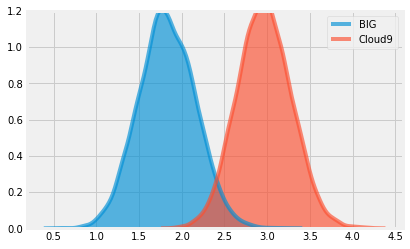

In [193]:
plt.ylim(0,1.2)
sns.kdeplot(trace_1, shade=True, alpha=0.65, legend=True, label=v['1'])
sns.kdeplot(trace_2, shade=True, alpha=0.65, legend=True, label=v['2'])

In [47]:
h_bp.groupby('Match ID').first().count()

Team          8051
Pick #        8051
 Pick Type    8051
Map           8051
dtype: int64

In [19]:
h_bp

,Match ID,Team,Pick #,Pick Type,Map
0,2311123/north-academy-vs-midlertidig-dust2dk-e...,midlertidig,1,removed,Train
1,2311123/north-academy-vs-midlertidig-dust2dk-e...,North Academy,2,removed,Overpass
2,2311123/north-academy-vs-midlertidig-dust2dk-e...,midlertidig,3,removed,Nuke
3,2311123/north-academy-vs-midlertidig-dust2dk-e...,North Academy,4,removed,Cobblestone
4,2311123/north-academy-vs-midlertidig-dust2dk-e...,midlertidig,5,removed,Mirage
5,2311123/north-academy-vs-midlertidig-dust2dk-e...,North Academy,6,removed,Inferno
6,2311123/north-academy-vs-midlertidig-dust2dk-e...,NaN,7,random,Cache
7,2310837/binary-dragons-vs-ttfu-dolphincs-shoot...,TTFU,1,removed,Cache
8,2310837/binary-dragons-vs-ttfu-dolphincs-shoot...,Binary Dragons,2,removed,Overpass
9,2310837/binary-dragons-vs-ttfu-dolphincs-shoot...,TTFU,3,picked,Inferno
